In [95]:
# Import all the necessary libraries for the notebook
import matplotlib.pyplot as plt
%matplotlib widget

from skn.query import Query
from skn.CAN.fields.channels import *
from skn.CAN.tags.tags import *

import pandas as pd
import numpy as np

from skn.query import Query

import sys

from skn import utils
from skn.query import Query
from skn.plotting_service import PlottingService
from skn.simple_plotter import SimplePlotter

from skn.CAN.fields.channels import *
from skn.CAN.tags.tags import *

In [98]:
# Display/Locate logs
Query().all_tags( Car.HERA).print_logs()

log_id:      CAN_2024_05_23_141547
car:         Hera
comment:     First charging of Hera Accu
location:    Workshop
log_name:    Charging 23.05.24
log_type:    CHARGE
driver:      
event:       
competition: 


log_id:      CAN_2024_06_02_212534
car:         Hera
comment:     
location:    Dragvoll
log_name:    5laps_drive_hera
log_type:    TEST_DRIVE
driver:      Eivind Due-Tønnesen
event:       Shakedown
competition: 


log_id:      CAN_2024_06_11_210229
car:         Hera
comment:     Static mode, 4Nm, 8krpm
location:    Other
log_name:    Magnus first drive
log_type:    TEST_DRIVE
driver:      Magnus Husby
event:       Autocross
competition: 


log_id:      CAN_2024_06_11_211707
car:         Hera
comment:     Successful attempt, 2-4m/s
location:    Other
log_name:    DVSV first try
log_type:    TEST_DRIVE
driver:      Driverless
event:       Shakedown
competition: 


log_id:      CAN_2024_06_11_213612
car:         Hera
comment:     AS second DVSV, 6kmh, still no INS, many issues rel

In [ ]:
import re

log_text = """





"""  # (Replace with your full output)

logs = {}
current_log_id = None
current_log = {}

for line in log_text.strip().splitlines():
    line = line.strip()
    if not line:
        # Blank line indicates end of one log block
        if current_log_id:
            logs[current_log_id] = current_log
        current_log_id = None
        current_log = {}
    else:
        if line.startswith("log_id:"):
            current_log_id = line.split(":")[1].strip()
        else:
            key, value = line.split(":", 1)
            current_log[key.strip()] = value.strip()

# Catch the last log (if no trailing blank line)
if current_log_id and current_log_id not in logs:
    logs[current_log_id] = current_log

# --- Result ---
print(logs)

{'CAN_2021_10_18_184710': {'car': 'Atmos', 'comment': 'Slid out run 9', 'competition': '', 'driver': 'Driverless', 'event': 'Skidpad', 'location': 'E.C. Dahls', 'log_name': 'Torque_test_skidpad_run_7_8_9', 'log_type': 'TEST_DRIVE'}}


import power data  

In [93]:

results = {}
invalid_log_ids = []

for log_id in logs.keys():
    print(f"Processing log_id: {log_id}")
    if not log_id in Log_id.__members__:
        print(f"Skipping invalid log_id: {log_id}", "Log_name:", logs[log_id].get('log_name', 'N/A'))
        invalid_log_ids = invalid_log_ids if 'invalid_log_ids' in locals() else []
        invalid_log_ids.append(log_id)
        continue
    results[log_id] = Query().all_tags(getattr(Log_id, log_id)).channels(AMS.TSDATA.POWER).execute()
    print(f"Processed log_id: {log_id}", "Log_name:", logs[log_id].get('log_name', 'N/A'))
# Display the results
if 'invalid_log_ids' in locals():
    for log_id in invalid_log_ids:
        del logs[log_id]
        print(f"Removed invalid log_id: {log_id}")


Processing log_id: CAN_2021_10_18_184710


NoResultException: 

In [ ]:
for log_id in logs.keys():
    if log_id not in results:
        print(f"No results for log_id: {log_id}")
        continue
    globals()[f"run_{log_id}"] = results[log_id].to_numpy_arrays()




In [ ]:
def calculate_energy(power, dt):
    """
    Integrate power over time to get energy.
    :param power: Power in Watts
    :param dt: Time step in seconds
    :return: Energy in Joules
    """
    convert_to_kWh = 1 / (3600 * 1000)  # Convert Joules to kWh
    mask_used = power > 0  # Only consider positive power values
    mask_kers = power < 0  # Only consider negative power values (KERS)
    KERS = np.trapz(power[mask_kers], x=dt[mask_kers]) * convert_to_kWh
    used = np.trapz(power[mask_used], x=dt[mask_used]) * convert_to_kWh

    mask_average = abs(power) > 200  # Only consider non-zero power values for average

    return used, KERS, KERS + used , np.average(abs(power[mask_average])) 



In [ ]:
energy_results = {}

for log_id, run in [(k, globals()[f"run_{k}"]) for k in logs.keys()]:
    if log_id not in results:
        print(f"No data for log_id: {log_id}")
        continue
    used, kers, total, average = calculate_energy(run['TSData_power'], run['time'])
    energy_results[log_id] = {'used_kWh': used, 'kers_kWh': kers, 'total_kWh': total, 'average_W': average}

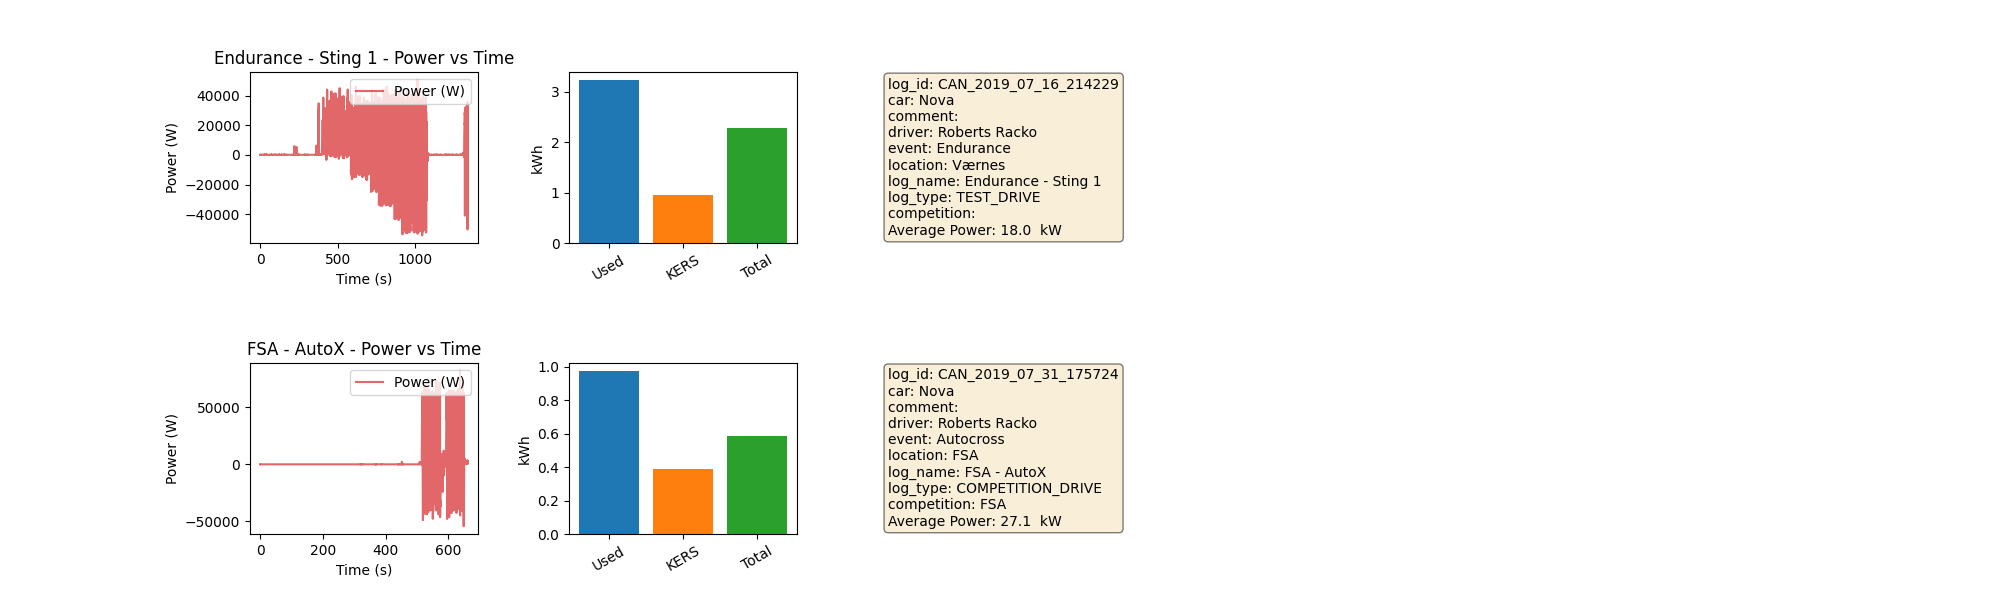

In [ ]:
from matplotlib.gridspec import GridSpec

labels = list(energy_results.keys())

fig, axs = plt.subplots(len(labels), 1, figsize=(20, 3 * len(labels)))  # Increase width for textbox
if len(labels) == 1:
    axs = [axs]

for i, log_id in enumerate(energy_results.keys()):
    used = energy_results[log_id]['used_kWh']
    kers = abs(energy_results[log_id]['kers_kWh'])  # Make KERS absolute
    total = energy_results[log_id]['total_kWh']
    average_W = energy_results[log_id]['average_W']

    # Only create the GridSpec and new axes on the first iteration
    if i == 0:
        fig.clf()
        # Increase width for bar plot and textbox (e.g., 2:1:2 ratio)
        gs = GridSpec(len(labels), 3, width_ratios=[0.5, 0.5, 2], figure=fig)
        axs_power = []
        axs_bar = []
        axs_text = []
        for row in range(len(labels)):
            axs_power.append(fig.add_subplot(gs[row, 0]))
            axs_bar.append(fig.add_subplot(gs[row, 1]))
            axs_text.append(fig.add_subplot(gs[row, 2]))
            axs_text[-1].axis('off')  # Hide axis for textbox

    ax_power = axs_power[i]
    ax_bar = axs_bar[i]
    ax_text = axs_text[i]

    # Power vs time
    run = globals()[f"run_{log_id}"]
    ax_power.plot(run['time'], run['TSData_power'], color='tab:red', alpha=0.7, label='Power (W)')
    ax_power.set_ylabel('Power (W)')
    ax_power.set_xlabel('Time (s)')
    ax_power.set_title(f"{logs[log_id]['log_name']} - Power vs Time")
    ax_power.legend(loc='upper right')

    # Bar plot for energy
    ax_bar.bar(['Used', 'KERS', 'Total'], [used, kers, total], color=['tab:blue', 'tab:orange', 'tab:green'])
    ax_bar.set_ylabel('kWh')
    ax_bar.autoscale(enable=True, axis='y')
    ax_bar.tick_params(axis='x', rotation=30)

    # Text box with log info
    log_info = f"log_id: {log_id}\n" + "\n".join([f"{k}: {v}" for k, v in logs[log_id].items()]) + "\n" f"Average Power: {round(average_W/1000,1)}  kW"
    ax_text.text(0, 0.5, log_info, fontsize=10, verticalalignment='center', bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))

plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()
